# Matrix Multiplication CUDA Benchmark

In [1]:
import sys
import triton

sys.path.append("../../build/cuda-snippets/matmul/")

import matmul

## Naive Implementation

![](./assets/naive.drawio.svg)

In [2]:
import torch

a = torch.randn(1024, 1024, device="cuda", dtype=torch.float32)
b = torch.randn(1024, 1024, device="cuda", dtype=torch.float32)
c = matmul.matmul_naive(a, b)
print("match: ", torch.allclose(c, a @ b))

match:  True


## Tiled Matrix Multiplication with shared memory

Matrix multiplication using shared memory tiling for better cache utilization"


In [3]:
import torch

a = torch.randn(1024, 1024, device="cuda", dtype=torch.float32)
b = torch.randn(1024, 1024, device="cuda", dtype=torch.float32)
c = matmul.matmul_tiled_smem(a, b)
print("match: ", torch.allclose(c, a @ b))

match:  True


## Increase the Arithmetic Intensity

Matrix multiplication using shared memory tiling with strided thread mapping for improved  memory access

In [4]:
import torch

a = torch.randn(1024, 1024, device="cuda", dtype=torch.float32)
b = torch.randn(1024, 1024, device="cuda", dtype=torch.float32)
c = matmul.matmul_strided_tiled(a, b)
print("match: ", torch.allclose(c, a @ b))

match:  True


## Use Float4 to copy shared more efficiency


Matrix multiplication using float4 vectorized loads/stores with shared memory and coalesced memory access

In [5]:
import torch

a = torch.randn(1024, 1024, device="cuda", dtype=torch.float32)
b = torch.randn(1024, 1024, device="cuda", dtype=torch.float32)
c = matmul.matmul_float4_smem_coalesced(a, b)
print("match: ", torch.allclose(c, a @ b))

match:  True


## Benchmark Testing

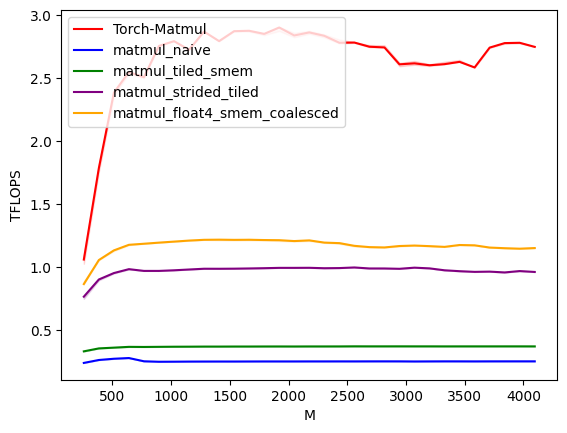

In [6]:
providers = [
    "Torch-Matmul",
    "matmul_naive",
    "matmul_tiled_smem",
    "matmul_strided_tiled",
    "matmul_float4_smem_coalesced",
]

styles = [("red", "-"), ("blue", "-"), ("green", "-"), ("purple", "-"), ("orange", "-")]


@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],
        x_vals=[128 * i for i in range(2, 33)],
        line_arg="provider",
        line_vals=providers,
        line_names=providers,
        styles=styles[: len(providers)],
        ylabel="TFLOPS",
        plot_name="matmul-performance",
        args={},
    )
)
def matmul_benchmark(M, N, K, provider):
    a = torch.randn((M, K), device="cuda")
    b = torch.randn((K, N), device="cuda")
    quantiles = [0.5, 0.2, 0.8]
    if provider == "Torch-Matmul":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles
        )
    if provider == "matmul_naive":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: matmul.matmul_naive(a, b), quantiles=quantiles
        )
    if provider == "matmul_tiled_smem":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: matmul.matmul_tiled_smem(a, b), quantiles=quantiles
        )
    if provider == "matmul_strided_tiled":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: matmul.matmul_strided_tiled(a, b),
            quantiles=quantiles,
        )
    if provider == "matmul_float4_smem_coalesced":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: matmul.matmul_float4_smem_coalesced(a, b),
            quantiles=quantiles,
        )
    perf = lambda ms: 2 * M * N * K * 1e-9 / ms
    return perf(ms), perf(max_ms), perf(min_ms)


matmul_benchmark.run(show_plots=True, print_data=False)